In [2]:
import os
from pathlib import Path

local_root_directory = '/Users/stefanduprey/Documents/My_Data/My_TitanicData/'
path = Path(local_root_directory)

if path.exists():
    raise Exception('already downloaded')
    
import zipfile,kaggle
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

Exception: already downloaded

In [3]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,NaN,S
414,1306,1,1,"Oliva y Ocana, Dona. Fermina",female,39.00,0,0,PC 17758,108.90,C105,C
415,1307,0,3,"Saether, Mr. Simon Sivertsen",male,38.50,0,0,SOTON/O.Q. 3101262,7.25,NaN,S
416,1308,0,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,NaN,S


In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [6]:
splits = RandomSplitter(seed=42)(df)

In [7]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=path)

In [8]:
learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])

SuggestedLRs(slide=0.2089296132326126, valley=0.02754228748381138)

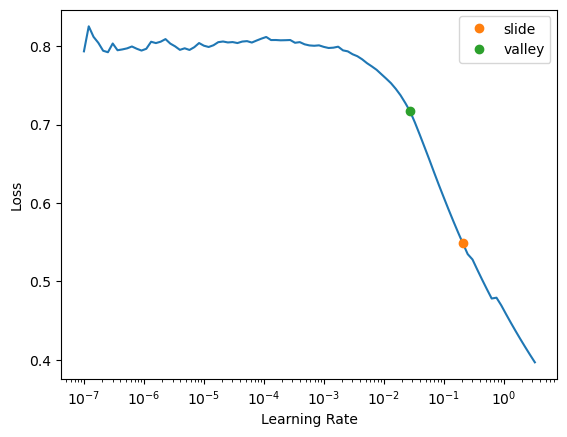

In [9]:
learn.lr_find(suggest_funcs=(slide, valley))

In [10]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.605926,0.644868,0.602410,00:00
1,0.407895,0.370422,0.783133,00:00
2,0.273544,0.031372,1.000000,00:00
3,0.195428,0.000940,1.000000,00:00
4,0.148231,0.000113,1.000000,00:00
5,0.116969,0.000037,1.000000,00:00
6,0.094827,0.000025,1.000000,00:00
7,0.078408,0.000024,1.000000,00:00
8,0.065800,0.000028,1.000000,00:00
9,0.055876,0.000030,1.000000,00:00


In [14]:
tst_df = pd.read_csv(path/'train.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)
tst_dl = learn.dls.test_dl(tst_df)
preds,_ = learn.get_preds(dl=tst_dl)
tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)
!head sub.csv

PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [15]:
def ensemble():
    learn = tabular_learner(dls, metrics=accuracy, layers=[10,10])
    with learn.no_bar(),learn.no_logging(): learn.fit(16, lr=0.03)
    return learn.get_preds(dl=tst_dl)[0]

In [16]:
learns = [ensemble() for _ in range(5)]

In [17]:
ens_preds = torch.stack(learns).mean(0)

In [18]:
tst_df['Survived'] = (ens_preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('ens_sub.csv', index=False)